In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_dir = "gdrive/My Drive/vehicles_images"

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 4318 files belonging to 4 classes.
Using 3455 files for training.
Found 4318 files belonging to 4 classes.
Using 863 files for validation.
['bus', 'motorcycle', 'plane', 'train']


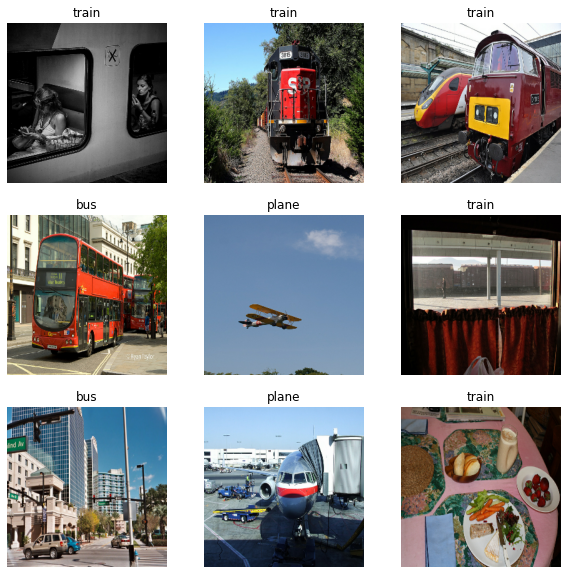

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


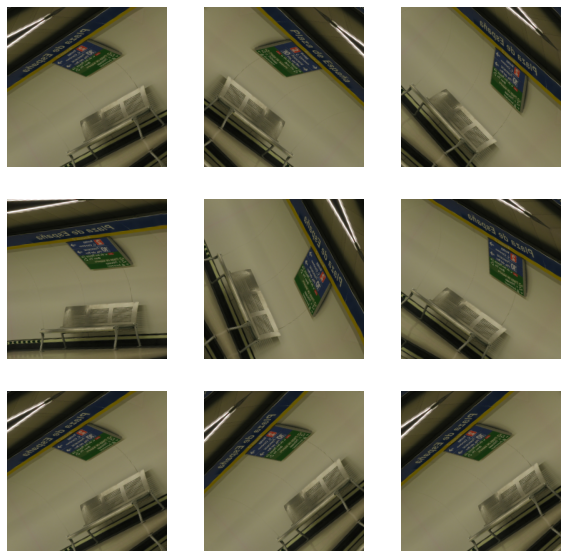

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [ ]:
# I did normalization to make the pixel value range between 0 and 1
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))
num_classes = 4


0.0314951 1.0


## MAX POOLING

In [ ]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
# I want to change the stride size and filters of the Conv2D layer
tf.keras.layers.Conv2D(
    filters = 1,
    kernel_size = 1,
    strides = (1,1),
    padding = 'valid',
    data_format = None,
    dilation_rate = (1,1),
    groups = 1,
    activation = None,
    use_bias = True,
    kernel_initializer = 'glorot_uniform',
    bias_initializer = 'zeros',
    activity_regularizer = None,
    kernel_constraint = None,
    bias_constraint = None,
)

In [ ]:
%%time
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/10
108/108 [==============================] - 419s 4s/step - loss: 1.3668 - accuracy: 0.4104 - val_loss: 1.1171 - val_accuracy: 0.5585
Epoch 2/10
108/108 [==============================] - 222s 2s/step - loss: 1.0009 - accuracy: 0.5867 - val_loss: 1.0272 - val_accuracy: 0.5446
Epoch 3/10
108/108 [==============================] - 219s 2s/step - loss: 0.8736 - accuracy: 0.6576 - val_loss: 1.0081 - val_accuracy: 0.5956
Epoch 4/10
108/108 [==============================] - 217s 2s/step - loss: 0.6554 - accuracy: 0.7557 - val_loss: 1.1464 - val_accuracy: 0.5295
Epoch 5/10
108/108 [==============================] - 218s 2s/step - loss: 0.4217 - accuracy: 0.8498 - val_loss: 1.3210 - val_accuracy: 0.5643
Epoch 6/10
108/108 [==============================] - 220s 2s/step - loss: 0.2713 - accuracy: 0.9140 - val_loss: 1.4807 - val_accuracy: 0.5597
Epoch 7/10
108/108 [==============================] - 220s 2s/step - loss: 0.1973 - accuracy: 0.9473 - val_loss: 1.6151 - val_accuracy: 0.5574

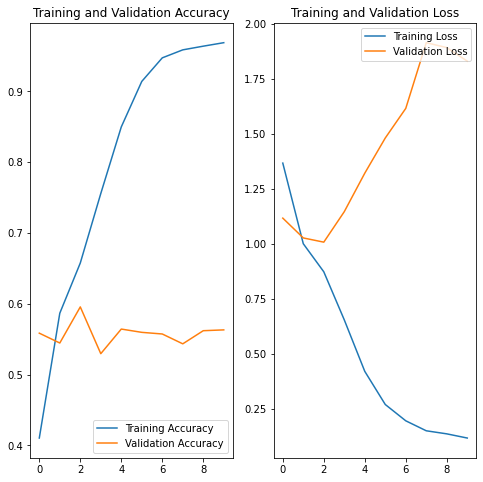

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## AVERAGE POOLING

In [ ]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(num_classes)
])

model.compile(optimizer='RMSprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 average_pooling2d (AverageP  (None, 128, 128, 16)     0         
 ooling2D)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 64, 64, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
tf.keras.layers.Conv2D(
    filters = 1,
    kernel_size = 1,
    strides = (1,1),
    padding = 'valid',
    data_format = None,
    dilation_rate = (1,1),
    groups = 1,
    activation = None,
    use_bias = True,
    kernel_initializer = 'glorot_uniform',
    bias_initializer = 'zeros',
    activity_regularizer = None,
    kernel_constraint = None,
    bias_constraint = None,
)

In [ ]:
%%time
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/10
108/108 [==============================] - 199s 2s/step - loss: 1.3467 - accuracy: 0.4168 - val_loss: 1.1113 - val_accuracy: 0.5075
Epoch 2/10
108/108 [==============================] - 195s 2s/step - loss: 1.0630 - accuracy: 0.5470 - val_loss: 1.0949 - val_accuracy: 0.5446
Epoch 3/10
108/108 [==============================] - 198s 2s/step - loss: 0.9283 - accuracy: 0.6191 - val_loss: 1.1049 - val_accuracy: 0.5469
Epoch 4/10
108/108 [==============================] - 196s 2s/step - loss: 0.7656 - accuracy: 0.6920 - val_loss: 1.1320 - val_accuracy: 0.5643
Epoch 5/10
108/108 [==============================] - 198s 2s/step - loss: 0.6147 - accuracy: 0.7690 - val_loss: 1.3286 - val_accuracy: 0.5261
Epoch 6/10
108/108 [==============================] - 198s 2s/step - loss: 0.4529 - accuracy: 0.8379 - val_loss: 1.3194 - val_accuracy: 0.5458
Epoch 7/10
108/108 [==============================] - 197s 2s/step - loss: 0.3366 - accuracy: 0.8793 - val_loss: 1.4999 - val_accuracy: 0.5516

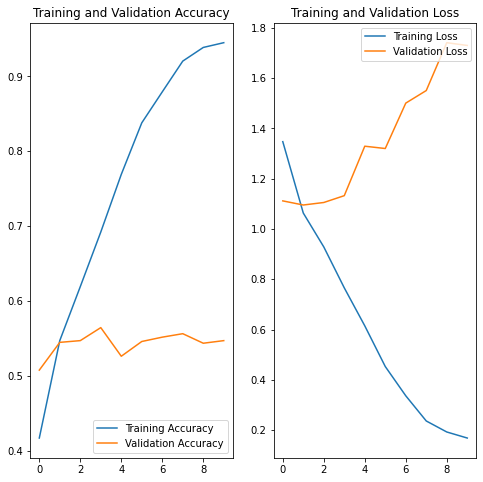

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## DEEPER NETWORKS WITH MORE LAYERS

In [ ]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 average_pooling2d (AverageP  (None, 128, 128, 16)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 64, 64, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
tf.keras.layers.Conv2D(
    filters = 3,
    kernel_size = 3,
    strides = (2,2),
    padding = 'valid',
    data_format = None,
    dilation_rate = (1,1),
    groups = 1,
    activation = None,
    use_bias = True,
    kernel_initializer = 'glorot_uniform',
    bias_initializer = 'zeros',
    activity_regularizer = None,
    kernel_constraint = None,
    bias_constraint = None,
)

In [ ]:
%%time
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/10
108/108 [==============================] - 257s 2s/step - loss: 1.2445 - accuracy: 0.4182 - val_loss: 1.1723 - val_accuracy: 0.4959
Epoch 2/10
108/108 [==============================] - 256s 2s/step - loss: 1.1101 - accuracy: 0.5111 - val_loss: 1.0655 - val_accuracy: 0.5342
Epoch 3/10
108/108 [==============================] - 256s 2s/step - loss: 1.0506 - accuracy: 0.5465 - val_loss: 1.0863 - val_accuracy: 0.5539
Epoch 4/10
108/108 [==============================] - 254s 2s/step - loss: 1.0226 - accuracy: 0.5618 - val_loss: 1.0360 - val_accuracy: 0.5492
Epoch 5/10
108/108 [==============================] - 255s 2s/step - loss: 0.9639 - accuracy: 0.5988 - val_loss: 0.9783 - val_accuracy: 0.5898
Epoch 6/10
108/108 [==============================] - 257s 2s/step - loss: 0.9125 - accuracy: 0.6124 - val_loss: 0.9322 - val_accuracy: 0.6211
Epoch 7/10
108/108 [==============================] - 257s 2s/step - loss: 0.8621 - accuracy: 0.6475 - val_loss: 0.9487 - val_accuracy: 0.6095

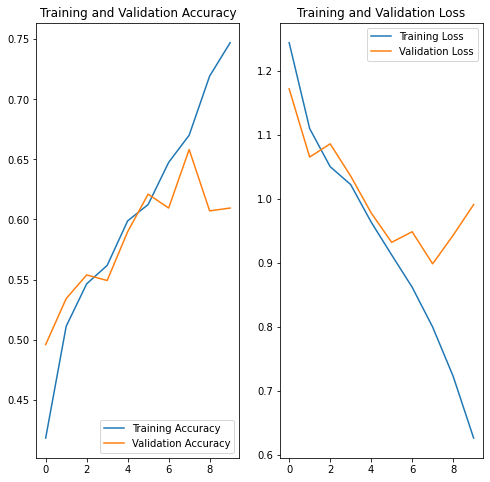

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# TRAINNING THE CNN ON 20 NEW IMAGES

In [ ]:
test_dir = "gdrive/My Drive/test_images"

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  shuffle=False,
  batch_size=batch_size)

class_names = test_ds.class_names
class_names

Found 20 files belonging to 4 classes.


['bus', 'motorcycle', 'plane', 'train']

In [ ]:
pred = model.predict(test_ds)
pred

array([[ 4.4363597e-04,  5.4052803e-03,  3.4940429e-04,  8.3166976e-03],
       [-2.3055039e-03,  8.3610956e-03,  1.4010947e-03,  8.2126167e-03],
       [ 1.6187597e-03,  3.7649998e-03,  5.0254799e-03,  1.3661450e-03],
       [-5.0545651e-03,  2.0653345e-02,  1.2048740e-02, -4.0576993e-03],
       [-3.8424621e-03, -1.6224188e-03, -2.1157665e-03,  1.1105720e-02],
       [ 1.1802576e-02, -2.8527693e-03, -3.5192734e-03,  1.4431765e-02],
       [ 1.4558983e-02,  2.1875061e-02,  7.6390235e-03,  2.3831995e-03],
       [-9.5316023e-03,  6.5514334e-03,  1.3271265e-02, -2.1824711e-03],
       [-5.8304900e-03,  1.8591208e-02,  5.3123040e-03, -2.1826420e-03],
       [-1.1973308e-02,  6.3227220e-03,  8.6351410e-03,  1.0140255e-02],
       [-7.6077860e-03,  5.8589093e-03,  1.6872132e-02,  6.4933975e-04],
       [-4.7515407e-03,  7.7368040e-03,  2.1596737e-03,  7.0798355e-03],
       [ 6.5716775e-04,  1.9865733e-02,  1.0350151e-02,  1.1039954e-03],
       [-4.5919791e-05,  1.1833942e-02,  3.3592936e

In [ ]:
pred_class = np.argmax(pred, axis =1)
[class_names[val] for val in pred_class]

['train',
 'motorcycle',
 'plane',
 'motorcycle',
 'train',
 'train',
 'motorcycle',
 'plane',
 'motorcycle',
 'train',
 'plane',
 'motorcycle',
 'motorcycle',
 'motorcycle',
 'plane',
 'train',
 'motorcycle',
 'train',
 'plane',
 'motorcycle']

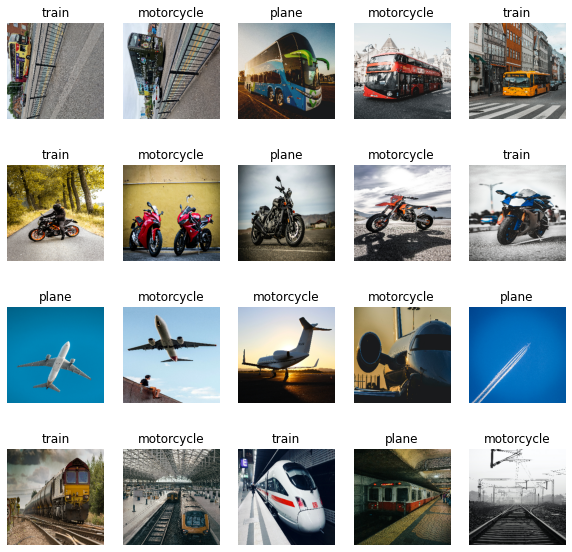

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[pred_class[i]])
    plt.axis("off")

In [ ]:
for _, labels in test_ds.take(1):
  print(labels)

tf.Tensor([0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3], shape=(20,), dtype=int32)


In [ ]:
val_classes  = [labels.numpy() for _, label in test_ds.take(1)]

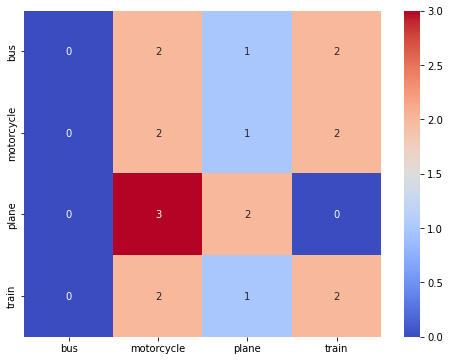

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(np.array(val_classes).reshape(20,1), pred_class)
plt.figure(figsize=(8,6))
sns.heatmap(confusion, annot = True, cmap = 'coolwarm', xticklabels= class_names, yticklabels = class_names)

## Using Maxpooling on the test dataset

In [ ]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.8),
  layers.Dense(100, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
pred2 = model.predict(test_ds)
pred2

In [ ]:
pred_class2 = np.argmax(pred2, axis =1)
[class_names[val] for val in pred_class2]

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion2 = confusion_matrix(np.array(val_classes).reshape(20,1), pred_class2)
plt.figure(figsize=(8,6))
sns.heatmap(confusion2, annot = True, cmap = 'coolwarm', xticklabels= class_names, yticklabels = class_names)

# IMAGENET SESSION

In [ ]:
IMG_SIZE = (256,256)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


In [ ]:
base_model.trainable = False
base_model.summary()



global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)



prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=(256,256,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

len(model.trainable_variables)
initial_epochs = 10
loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("inital accuracy: {:.2f}".format(accuracy0))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


27/27 [==============================] - 38s 1s/step - loss: 1.8963 - accuracy: 0.2074
initial loss: 1.90
inital accuracy: 0.21


In [ ]:
%%time
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data = val_ds)

# Saving model
model.save('gdrive/My Drive/Colab Notebooks/vehicles_images.h5')


Epoch 1/10
108/108 [==============================] - 202s 2s/step - loss: 1.5217 - accuracy: 0.3227 - val_loss: 1.2253 - val_accuracy: 0.4751
Epoch 2/10
108/108 [==============================] - 194s 2s/step - loss: 1.1231 - accuracy: 0.5271 - val_loss: 0.9546 - val_accuracy: 0.6582
Epoch 3/10
108/108 [==============================] - 195s 2s/step - loss: 0.9414 - accuracy: 0.6185 - val_loss: 0.7845 - val_accuracy: 0.7335
Epoch 4/10
108/108 [==============================] - 192s 2s/step - loss: 0.8326 - accuracy: 0.6750 - val_loss: 0.6903 - val_accuracy: 0.7625
Epoch 5/10
108/108 [==============================] - 197s 2s/step - loss: 0.7714 - accuracy: 0.6944 - val_loss: 0.6256 - val_accuracy: 0.7845
Epoch 6/10
108/108 [==============================] - 196s 2s/step - loss: 0.7185 - accuracy: 0.7279 - val_loss: 0.5868 - val_accuracy: 0.7972
Epoch 7/10
108/108 [==============================] - 194s 2s/step - loss: 0.6852 - accuracy: 0.7378 - val_loss: 0.5557 - val_accuracy: 0.8111

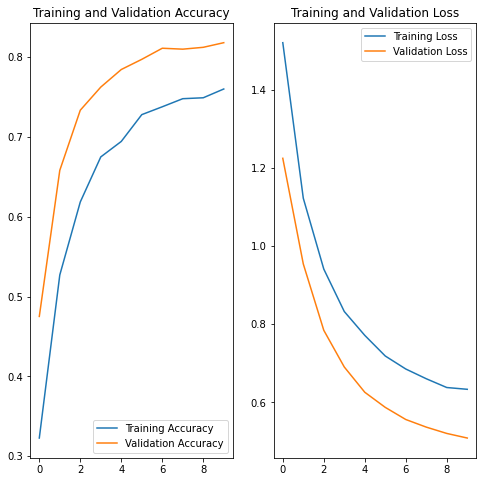

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
base_model.trainable = True
base_model.summary()

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)



Epoch 10/20
108/108 [==============================] - 301s 3s/step - loss: 0.6274 - accuracy: 0.7546 - val_loss: 0.4538 - val_accuracy: 0.8540
Epoch 11/20
108/108 [==============================] - 293s 3s/step - loss: 0.4921 - accuracy: 0.8098 - val_loss: 0.4437 - val_accuracy: 0.8378
Epoch 12/20
108/108 [==============================] - 294s 3s/step - loss: 0.4462 - accuracy: 0.8220 - val_loss: 0.4611 - val_accuracy: 0.8343
Epoch 13/20
108/108 [==============================] - 296s 3s/step - loss: 0.4379 - accuracy: 0.8347 - val_loss: 0.4651 - val_accuracy: 0.8378
Epoch 14/20
108/108 [==============================] - 295s 3s/step - loss: 0.3883 - accuracy: 0.8521 - val_loss: 0.4690 - val_accuracy: 0.8505
Epoch 15/20
108/108 [==============================] - 295s 3s/step - loss: 0.3785 - accuracy: 0.8596 - val_loss: 0.4429 - val_accuracy: 0.8575
Epoch 16/20
108/108 [==============================] - 293s 3s/step - loss: 0.3157 - accuracy: 0.8810 - val_loss: 0.4935 - val_accuracy:

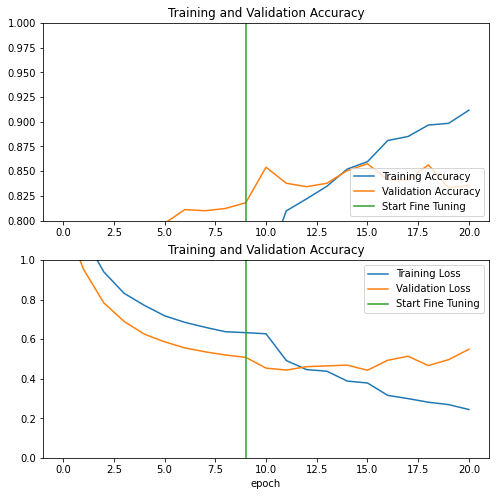

108/108 [==============================] - 143s 1s/step - loss: 0.1817 - accuracy: 0.9369
Test accuracy:  0.9369030594825745


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.show()

loss, accuracy = model.evaluate(train_ds)
print('Test accuracy: ', accuracy)

## Loading the saved model to evaluate the test dataset

# TF Explanability METHOD

In [ ]:
%%bash
pip install tf-explain -q

In [ ]:
from tf_explain.core.grad_cam import GradCAM


base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet',input_shape=(img_height, img_width, 3))
data = (x_test, None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, base_model, class_index=0)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "grad_cam.png")


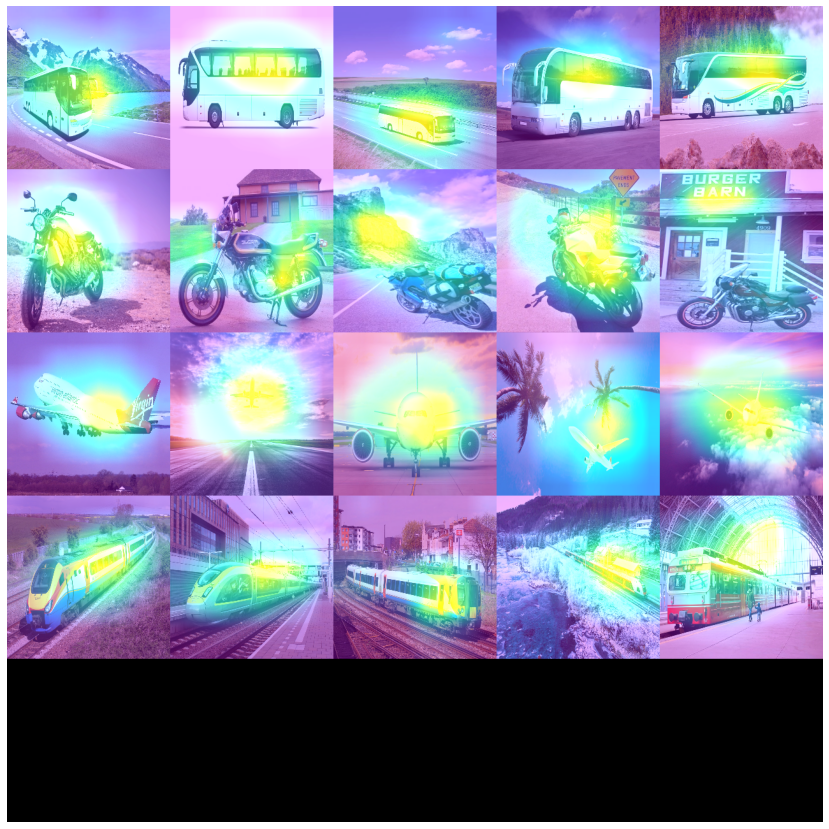

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(grid.astype("uint8"))
plt.axis('off')
plt.show()